In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, precision="double")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [2]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...


In [3]:
from manapy.solvers.ls import PETScKrylovSolver

# put this code to PETScKrylovSolver init function so bypass the import of petsc4py
"""
    # try_imports(['import petsc4py',],
    #             'cannot import petsc4py solver!')
    
    # from petsc4py import PETSc as petsc
    
    #self.petsc = petsc
    self.ksp   = None
    
    self.converged_reasons = {}                                                                                                                                                                             
    # for key, val in six.iteritems(petsc.KSP.ConvergedReason.__dict__):                                                                                                                                 
    #     if isinstance(val, int):                                                                                                                                                                       
    #         self.converged_reasons[val] = key    
"""

conf = Struct(reuse_mtx=True, scheme='diamond', verbose=False, precision="single")
L = PETScKrylovSolver(domain=domain, var=P, conf=conf)

SetUp the Linear system ...


In [4]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))


L.update_ghost_values()
L.var.BCdirichlet = L.domain.nodes.oldname

host_cellfid, d_cellfid = create_var(L.domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(L.domain.faces.nodeid)
host_oldname, d_oldname = create_var(L.domain.nodes.oldname)
host_volume, d_volume = create_var(L.domain.cells.volume)
host_centergn, d_centergn = create_var(L.domain.nodes.ghostcenter)
host_loctoglob, d_loctoglob = create_var(L.domain.cells.loctoglob)
host_param1, d_param1 = create_var(L.domain.faces.param1)
host_param2, d_param2 = create_var(L.domain.faces.param2)
host_param3, d_param3 = create_var(L.domain.faces.param3)
host_param4, d_param4 = create_var(L.domain.faces.param4)
host_Pbordnode, d_Pbordnode = create_var(L.domain.Pbordnode)
host_Pbordface, d_Pbordface = create_var(L.domain.Pbordface)
host_rhs_loc, d_rhs_loc = create_var(L.rhs0)
host_BCdirichlet, d_BCdirichlet = create_var(L.var.BCdirichlet)
host_centergf, d_centergf = create_var(L.domain.faces.ghostcenter)
host_matrixinnerfaces, d_matrixinnerfaces = create_var(L.matrixinnerfaces)
host_halofaces, d_halofaces = create_var(L.domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(L.var.dirichletfaces)




In [5]:
host_rhs_loc.dtype, d_rhs_loc.dtype

(dtype('float64'), dtype('float64'))

In [6]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def get_rhs_glob_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', oldname:'uint32[:]', 
                    volume:'float[:]', centergn:'float[:,:,:]', loctoglob:'int32[:]', param1:'float[:]', param2:'float[:]', 
                    param3:'float[:]', param4:'float[:]', Pbordnode:'float[:]', Pbordface:'float[:]',  rhs:'float[:]',
                    BCdirichlet:'uint32[:]', centergf:'float[:,:]', matrixinnerfaces:'uint32[:]',
                    halofaces:'uint32[:]', dirichletfaces:'uint32[:]'):                                                                                                                                                                       
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
    
    rhs[:] = 0.
    for i in matrixinnerfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            V = Pbordnode[i_1]
            value_left = -1. * V * param4[i] / volume[c_left]
            rhs[c_leftglob] +=  value_left
            
            value_right = V * param4[i] / volume[c_right]
            rhs[c_rightglob] += value_right
            
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            V = Pbordnode[i_2]
            value_left =  -1. * V * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
            
            value_right =  V * param2[i] / volume[c_right]
            rhs[c_rightglob] += value_right
                    
    for i in halofaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        if search_element(BCdirichlet, oldname[i_1]) == 1: 
            V = Pbordnode[i_1]
            value_left =  -1. * V * param4[i] / volume[c_left]
            rhs[c_leftglob] += value_left
        
        if search_element(BCdirichlet, oldname[i_2]) == 1: 
            V = Pbordnode[i_2]
            value_left =  -1. * V * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
            
    for i in dirichletfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]  
        
        if centergn[i_1][0][2] != -1:     
            V = Pbordnode[i_1]
            value_left = -1. * V * param4[i] / volume[c_left]
            rhs[c_leftglob] += value_left
           
        if centergn[i_2][0][2] != -1: 
            V = Pbordnode[i_2]
            value_left = -1. * V * param2[i] / volume[c_left]
            rhs[c_leftglob] += value_left
        
        V_K = Pbordface[i]
        value = -2. * param3[i] / volume[c_left] * V_K
        rhs[c_leftglob] += value


In [7]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_get_rhs_glob_2d = numba.jit(get_rhs_glob_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_get_rhs_glob_2d():
  return numba_get_rhs_glob_2d(
    host_cellfid,
    host_nodeidf,
    host_oldname,
    host_volume,
    host_centergn,
    host_loctoglob,
    host_param1,
    host_param2,
    host_param3,
    host_param4,
    host_Pbordnode,
    host_Pbordface,
    host_rhs_loc,
    host_BCdirichlet,
    host_centergf,
    host_matrixinnerfaces,
    host_halofaces,
    host_dirichletfaces,
  )


In [8]:
#time taken by cpu_get_rhs_glob_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

cpu_get_rhs_glob_2d()
test_time(70, cpu_get_rhs_glob_2d)

142.99520 ms


In [9]:
def find_duplicates(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    duplicates = unique_elements[counts > 1]
    return duplicates

#! there is duplicate elements on host_cellfid
#! this can cause a datarace between threads => solution => use atomic add 
find_duplicates(host_cellfid[:, 0])

array([     0,      1,      2, ..., 105765, 105793, 105802], dtype=int32)

In [10]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return True
    return False

@cuda.jit()
def kernel_get_rhs_glob_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', oldname:'uint32[:]', 
                    volume:'float[:]', centergn:'float[:,:,:]', loctoglob:'int32[:]', param1:'float[:]', param2:'float[:]', 
                    param3:'float[:]', param4:'float[:]', Pbordnode:'float[:]', Pbordface:'float[:]',  rhs:'float[:]',
                    BCdirichlet:'uint32[:]', centergf:'float[:,:]', matrixinnerfaces:'uint32[:]',
                    halofaces:'uint32[:]', dirichletfaces:'uint32[:]'):                                                                                                                                                                       
    
    idx = cuda.grid(1)
    
    #? rhs[:] = 0. => secondary kernel
    if idx < matrixinnerfaces.shape[0]:
        i = matrixinnerfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        if search_element(BCdirichlet, oldname[i_1]) == True: 
            V = Pbordnode[i_1]
            value_left = -1. * V * param4[i] / volume[c_left]
            #!rhs[c_leftglob] +=  value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
            
            value_right = V * param4[i] / volume[c_right]
            #!rhs[c_rightglob] += value_right
            cuda.atomic.add(rhs, c_rightglob, value_right)
            
        if search_element(BCdirichlet, oldname[i_2]) == True: 
            V = Pbordnode[i_2]
            value_left =  -1. * V * param2[i] / volume[c_left]
            #!rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
            
            value_right =  V * param2[i] / volume[c_right]
            #!rhs[c_rightglob] += value_right
            cuda.atomic.add(rhs, c_rightglob, value_right)
                    
    if idx < halofaces.shape[0]:
        i = halofaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]    
        
        if search_element(BCdirichlet, oldname[i_1]) == True: 
            V = Pbordnode[i_1]
            value_left =  -1. * V * param4[i] / volume[c_left]
            #!rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
        
        if search_element(BCdirichlet, oldname[i_2]) == True: 
            V = Pbordnode[i_2]
            value_left =  -1. * V * param2[i] / volume[c_left]
            #!rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
            
    if idx < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        i_1 = nodeidf[i][0]
        i_2 = nodeidf[i][1]  
        
        if centergn[i_1][0][2] != -1:     
            V = Pbordnode[i_1]
            value_left = -1. * V * param4[i] / volume[c_left]
            #!rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
           
        if centergn[i_2][0][2] != -1: 
            V = Pbordnode[i_2]
            value_left = -1. * V * param2[i] / volume[c_left]
            #!rhs[c_leftglob] += value_left
            cuda.atomic.add(rhs, c_leftglob, value_left)
        
        V_K = Pbordface[i]
        value = -2. * param3[i] / volume[c_left] * V_K
        #!rhs[c_leftglob] += value
        cuda.atomic.add(rhs, c_leftglob, value)
        




In [11]:
import numba


nb_element = max(host_matrixinnerfaces.shape[0], host_halofaces.shape[0] ,host_dirichletfaces.shape[0])
nb_threads = 32
nb_blocks = nb_element // nb_threads + 1
print(nb_blocks)
nb_blocks_rhs_loc = d_rhs_loc.shape[0] // nb_threads + 1


@cuda.jit
def kernel_zero(arr_out):
  i = cuda.grid(1)
  if i < arr_out.shape[0]:
    arr_out[i] = 0

def cuda_get_rhs_glob_2d():
  kernel_zero[nb_blocks_rhs_loc, nb_threads](d_rhs_loc)
  cuda.synchronize()
  kernel_get_rhs_glob_2d[nb_blocks, nb_threads](
    d_cellfid,
    d_nodeidf,
    d_oldname,
    d_volume,
    d_centergn,
    d_loctoglob,
    d_param1,
    d_param2,
    d_param3,
    d_param4,
    d_Pbordnode,
    d_Pbordface,
    d_rhs_loc,
    d_BCdirichlet,
    d_centergf,
    d_matrixinnerfaces,
    d_halofaces,
    d_dirichletfaces,
  )
  cuda.synchronize()

cuda_get_rhs_glob_2d()
test_time(70, cuda_get_rhs_glob_2d)

4949
16.58361 ms


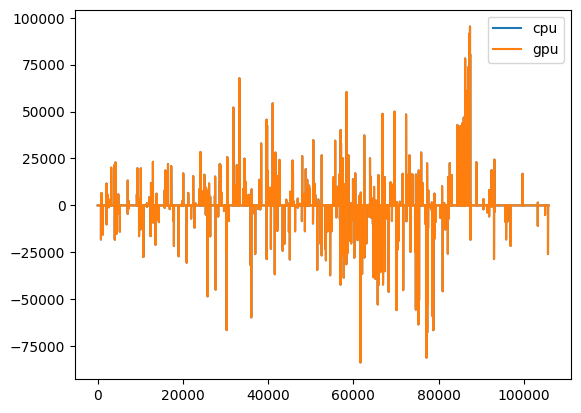

In [12]:
def verify(a, b, decimal, plot):
  b = b.copy_to_host()
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal, )


verify(host_rhs_loc, d_rhs_loc, decimal=2, plot=True)